## Imports {-}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import re
import contractions
import seaborn as sns

import spacy
nlp = spacy.load('en_core_web_sm')
all_stopwords = nlp.Defaults.stop_words

In [2]:
merged_df = pd.read_csv('/Users/JoKerry/Desktop/CSML1030 - Machine Learning Capstone/mimic_admissions_and_discharge/1 Data Preprocessing/mimic_text_labels_merged_cleaned_no_zeros.csv')
merged_df

,HADM_ID,SEQ_NUM,ICD9_CODE,CATEGORY,TEXT,AGE,ROW_ID,SUBJECT_ID,ADMISSION_TYPE
0,153714.0,1.0,5849,Discharge summary,Admission Date: [**2159-7-6**] Discharg...,51,29492,24136,EMERGENCY
1,165367.0,1.0,51881,Nursing/other,FOCUS; NURISNG PROGRESS NOTE\n(Continued)\nSPL...,65,36317,29799,EMERGENCY
2,129565.0,1.0,51881,Discharge summary,Admission Date: [**2146-6-1**] D...,79,47150,62854,EMERGENCY
3,141170.0,1.0,51881,Nursing,"Hypoglycemia\n Assessment:\n Pt. BS 114, 1...",65,36132,29631,EMERGENCY
4,184643.0,1.0,5849,Discharge summary,Admission Date: [**2136-1-21**] ...,59,17278,14106,EMERGENCY
...,...,...,...,...,...,...,...,...,...
31972,154989.0,32.0,53081,Nursing/other,Respiratory Care:\n\nPatient intubated for inc...,65,30465,24955,EMERGENCY
31973,133827.0,32.0,53081,Radiology,[**2194-4-24**] 2:07 PM\n CHEST PORT. LINE PLA...,73,48045,65659,ELECTIVE
31974,179548.0,32.0,4019,Discharge summary,Admission Date: [**2182-8-1**] [...,79,48580,67348,EMERGENCY
31975,129551.0,36.0,4019,Radiology,[**2160-5-11**] 1:51 PM\n LUMBAR PUNCTURE ...,51,51769,77282,EMERGENCY


## Filter AGE > 120 {-}

In [3]:
merged_df[merged_df['AGE']>120]

,HADM_ID,SEQ_NUM,ICD9_CODE,CATEGORY,TEXT,AGE,ROW_ID,SUBJECT_ID,ADMISSION_TYPE


In [4]:
# merged_df.drop(merged_df[merged_df.AGE > 120].index, inplace=True)
# merged_df

## Filtering AGE = 0 {-}

In [5]:
(merged_df['AGE']==0).sum()

0

In [6]:
# merged_df.drop(merged_df[merged_df.AGE == 0].index, inplace=True)
# merged_df.info()

## Age Distribution on Current Data {-}

<AxesSubplot:xlabel='AGE', ylabel='Count'>

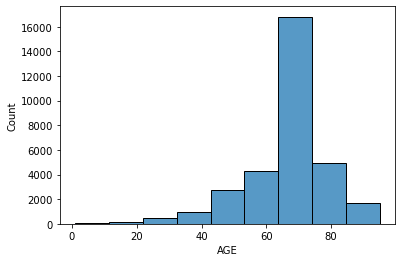

In [7]:
sns.histplot(data=merged_df, x='AGE', bins=9)

## Age Distribution on Labels {-}

<AxesSubplot:>

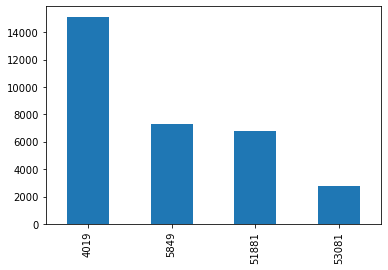

In [8]:
merged_df['ICD9_CODE'].value_counts().plot(kind='bar')

In [9]:
merged_4019 = merged_df[merged_df['ICD9_CODE'] == 4019]
merged_5849 = merged_df[merged_df['ICD9_CODE'] == 5849]
merged_51881 = merged_df[merged_df['ICD9_CODE'] == 51881]
merged_53081 = merged_df[merged_df['ICD9_CODE'] == 53081]

In [10]:
merged_4019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15125 entries, 15 to 31975
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HADM_ID         15125 non-null  float64
 1   SEQ_NUM         15125 non-null  float64
 2   ICD9_CODE       15125 non-null  int64  
 3   CATEGORY        15125 non-null  object 
 4   TEXT            15125 non-null  object 
 5   AGE             15125 non-null  int64  
 6   ROW_ID          15125 non-null  int64  
 7   SUBJECT_ID      15125 non-null  int64  
 8   ADMISSION_TYPE  15125 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 1.2+ MB


<AxesSubplot:xlabel='AGE', ylabel='Density'>

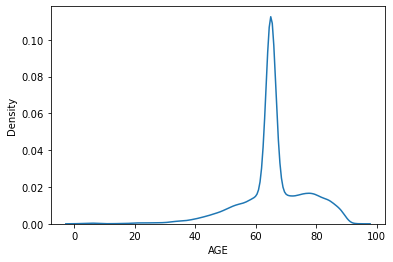

In [11]:
# label = 4019
sns.kdeplot(data=merged_4019, x='AGE')

<AxesSubplot:xlabel='AGE', ylabel='Density'>

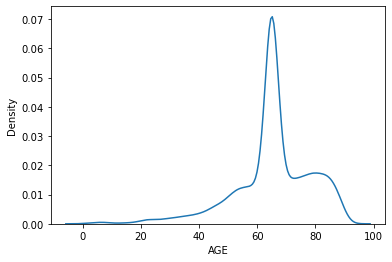

In [12]:
# label = 5849
sns.kdeplot(data=merged_5849, x='AGE')

<AxesSubplot:xlabel='AGE', ylabel='Density'>

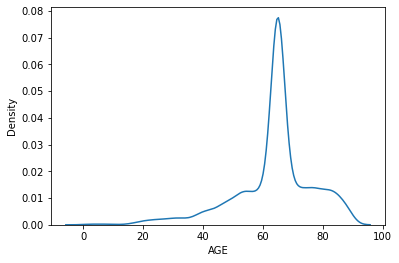

In [13]:
# label = 51881
sns.kdeplot(data=merged_51881, x='AGE')

<AxesSubplot:xlabel='AGE', ylabel='Density'>

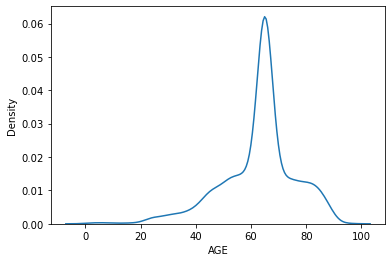

In [14]:
# label = 53081
sns.kdeplot(data=merged_53081, x='AGE')

In [15]:
print(merged_df.TEXT[31285])

82 YR. OLD MAN S/P FALL AT HOME->LG L. SDH WITH SHIFT. INTUBATED FOR AIRWAY PROTECTION. [**7-19**]->OR FOR EVACUATION OF SDH C/B NSTEMI & STROKE.
REMAINS UNRESPONSIVE SINCE SURGERY. DNR->MOVING TOWARDS CMO.

NEURO: UNRESPONSIVE. DOES NOT OPEN EYES. DOES NOT FOLLOW COMMANDS. DOES NOT HAVE ANY PURPOSEFUL MOVEMENTS. PUPILS PINPOINT.

RESP: ON VENT: 40%/TV 550/AC 14/PEEP 5. BS COURSE BUT DIMINISHED AT BASES. RR 21-26/14. O2 SAT 100%. SX FOR SM.-MOD. AMTS THICK WHITE SPUTUM.

CARDIAC: HR 66-91 SR WITH RARE PVC/COUPLET. BP 90-123/35-66. CVP 3-10.

GI:  NPO. OGT IN PLACE FOR MEDS. ABD SL. DISTENDED. BS HYPOACTIVE. SM. AMT. GOLDEN LIQUID STOOL VIA MUSHROOM CATHETER.

GU: FOLEY->CD PATENT & DRAINING YELLOW URINE WITH SEDIMENT. U/O 25-60
CC/HR.

ID: T(MAX)99.8(PO). CONT ON IV VANCO, PIPERACILLIN, & FLAGGYL. SPUTUM C&S (-), URINE C&S (-), STOOL C DIFF (-) X1->2 MORE PENDING. MRSA SCREEN (-). BC PENDING.

SKIN: HEAD INCISION OTA, C&D, SL. PINK. DUODERM INTACT TO R. GLUT.

ENDO: BS 183->177. INSULI

In [16]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31977 entries, 0 to 31976
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HADM_ID         31977 non-null  float64
 1   SEQ_NUM         31977 non-null  float64
 2   ICD9_CODE       31977 non-null  int64  
 3   CATEGORY        31977 non-null  object 
 4   TEXT            31977 non-null  object 
 5   AGE             31977 non-null  int64  
 6   ROW_ID          31977 non-null  int64  
 7   SUBJECT_ID      31977 non-null  int64  
 8   ADMISSION_TYPE  31977 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 2.2+ MB


## Additional Data Preprocessing {-}

In [17]:
def filter_discharge_text(notes_df) -> pd.DataFrame:
    """
    Filter text information by section and only keep sections that are known on discharge time.
    """
    discharge_sections = {
        "DISCHARGE_DIAGNOSIS": "discharge diagnosis:",
        "DISCHARGE_MEDICATIONS": "discharge medications:",
        "DISCHARGE_DISPOSITION": "discharge disposition:",
        "DISCHARGE_CONDITION": "discharge condition:",
        "DISCHARGE_INSTRUCTIONS": "discharge instructions:",
        "DISCHARGE_STATUS": "discharge status:",
        #"SECONDARY_DIAGNOSIS": "secondary diagnosis:",
        "MEDICATION_CHANGES": "medication changes:",
        "CONDITION_ON_DISCHARGE": "condition on discharge:",
        "MEDICATIONS_ON_DISCHARGE": "medications on discharge:",
        "DISPOSITION": "disposition:",
        #"DISCHARGE_INSTRUCTIONS/FOLLOWUP": "discharge instructions/followup:",
        #"SECONDARY": "secondary:"
    }

    # replace linebreak indicators
    notes_df['TEXT'] = notes_df['TEXT'].str.replace(r"\n", r"\\n")

    # extract each section by regex
    for key in discharge_sections.keys():
        section = discharge_sections[key]
        notes_df[key] = notes_df.TEXT.str.extract(r'(?i){}(.+?)\\n\\n[^(\\|\d|\.)]+?:'
                                                  .format(section))

        notes_df[key] = notes_df[key].str.replace(r'\\n', r' ')
        notes_df[key] = notes_df[key].str.strip()
        notes_df[key] = notes_df[key].fillna("")
        notes_df[notes_df[key].str.startswith("[]")][key] = ""
        

    # add section headers and combine into TEXT_DISCHARGE
    notes_df = notes_df.assign(TEXT="DISCHARGE DIAGNOSIS: " + notes_df.DISCHARGE_DIAGNOSIS.astype(str)
                                    + '\n\n' +
                                    "DISCHARGE MEDICATIONS: " + notes_df.DISCHARGE_MEDICATIONS.astype(str)
                                    + '\n\n' +
                                    "DISCHARGE DISPOSITION: " + notes_df.DISCHARGE_DISPOSITION.astype(str)
                                    + '\n\n' +
                                    "DISCHARGE CONDITION: " + notes_df.DISCHARGE_CONDITION.astype(str)
                                    + '\n\n' +
                                    "DISCHARGE INSTRUCTIONS: " + notes_df.DISCHARGE_INSTRUCTIONS.astype(str)
                                    + '\n\n' +
                                    "DISCHARGE STATUS: " + notes_df.DISCHARGE_STATUS.astype(str)
#                                     + '\n\n' +
#                                     "SECONDARY DIAGNOSIS: " + notes_df.SECONDARY_DIAGNOSIS.astype(str)
                                    + '\n\n' +
                                    "MEDICATION CHANGES: " + notes_df.MEDICATION_CHANGES.astype(str)
                                    + '\n\n' +
                                    "CONDITION ON DISCHARGE: " + notes_df.CONDITION_ON_DISCHARGE.astype(str)
                                    + '\n\n' +
                                    "MEDICATIONS ON DISCHARGE: " + notes_df.MEDICATIONS_ON_DISCHARGE.astype(str)
                                    + '\n\n' +
                                    "DISPOSITION: " + notes_df.DISPOSITION.astype(str))
                                    #+ '\n\n' +
                                    #"DISCHARGE INSTRUCTIONS/FOLLOWUP: " + notes_df.DISCHARGE_INSTRUCTIONS/FOLLOWUP.astype(str)
#                                     + '\n\n' +
#                                     "SECONDARY: " + notes_df.SECONDARY.astype(str))

    return notes_df

In [18]:
merged_df_filter_discharge = filter_discharge_text(merged_df)

<ipython-input-17-942b5e9d5915>:22: FutureWarning: The default value of regex will change from True to False in a future version.
  notes_df['TEXT'] = notes_df['TEXT'].str.replace(r"\n", r"\\n")
<ipython-input-17-942b5e9d5915>:30: FutureWarning: The default value of regex will change from True to False in a future version.
  notes_df[key] = notes_df[key].str.replace(r'\\n', r' ')


In [19]:
print(merged_df_filter_discharge.TEXT[10])

DISCHARGE DIAGNOSIS: Primary: Hypercarbic Respiratory failure Pneumonia COPD exacerbation  Secondary Bipolar GERD

DISCHARGE MEDICATIONS: 1. Olanzapine 5 mg Tablet Sig: 1.5 Tablets PO DAILY (Daily). 2. Pantoprazole 40 mg Tablet, Delayed Release (E.C.) Sig: One (1) Tablet, Delayed Release (E.C.) PO Q24H (every 24 hours). 3. Fluticasone-Salmeterol 250-50 mcg/Dose Disk with Device Sig: One (1) Disk with Device Inhalation [**Hospital1 **] (2 times a day). 4. Tiotropium Bromide 18 mcg Capsule, w/Inhalation Device Sig: One (1) Cap Inhalation DAILY (Daily). 5. Sertraline 100 mg Tablet Sig: 1.5 Tablets PO DAILY (Daily). 6. Levofloxacin 500 mg Tablet Sig: One (1) Tablet PO Q24H (every 24 hours) for 1 days. Disp:*1 Tablet(s)* Refills:*0* 7. Albuterol 90 mcg/Actuation Aerosol Sig: [**1-5**]  Inhalation four times a day as needed for wheezing. 8. Trazodone 50 mg Tablet Sig: One (1) Tablet PO at bedtime. 9. Klonopin 1 mg Tablet Sig: 1.5 Tablets PO qAM. 10. Klonopin 1 mg Tablet Sig: One (1) Tablet P

In [20]:
merged_df_filter_discharge.head()

,HADM_ID,SEQ_NUM,ICD9_CODE,CATEGORY,TEXT,AGE,ROW_ID,SUBJECT_ID,ADMISSION_TYPE,DISCHARGE_DIAGNOSIS,DISCHARGE_MEDICATIONS,DISCHARGE_DISPOSITION,DISCHARGE_CONDITION,DISCHARGE_INSTRUCTIONS,DISCHARGE_STATUS,MEDICATION_CHANGES,CONDITION_ON_DISCHARGE,MEDICATIONS_ON_DISCHARGE,DISPOSITION
0,153714.0,1.0,5849,Discharge summary,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,51,29492,24136,EMERGENCY,,1. Lasix 20 mg p.o. q.d. with instructions to ...,,Good.,,,,,,
1,165367.0,1.0,51881,Nursing/other,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,65,36317,29799,EMERGENCY,,,,,,,,,,
2,129565.0,1.0,51881,Discharge summary,DISCHARGE DIAGNOSIS: PRIMARY DIAGNOSIS: Respir...,79,47150,62854,EMERGENCY,PRIMARY DIAGNOSIS: Respiratory failure Mucous ...,1. B complex-vitamin C-folic acid 1 mg Capsule...,Extended Care,Mental Status: Clear and coherent. Level of Co...,It was a pleasure taking care of you during yo...,,--*ADDED* Aspirin 81mg daily --*ADDED* Atorvas...,,,Extended Care
3,141170.0,1.0,51881,Nursing,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,65,36132,29631,EMERGENCY,,,,,,,,,,
4,184643.0,1.0,5849,Discharge summary,DISCHARGE DIAGNOSIS: primary: cardiac arrest a...,59,17278,14106,EMERGENCY,primary: cardiac arrest acute on chronic renal...,1. Aspirin 325 mg Tablet Sig: One (1) Tablet P...,Home,good,You were admitted as a transfer from [**Hospit...,,,,,Home


In [21]:
merged_df_filter_discharge = merged_df_filter_discharge.iloc[:, :8]
merged_df_filter_discharge

,HADM_ID,SEQ_NUM,ICD9_CODE,CATEGORY,TEXT,AGE,ROW_ID,SUBJECT_ID
0,153714.0,1.0,5849,Discharge summary,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,51,29492,24136
1,165367.0,1.0,51881,Nursing/other,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,65,36317,29799
2,129565.0,1.0,51881,Discharge summary,DISCHARGE DIAGNOSIS: PRIMARY DIAGNOSIS: Respir...,79,47150,62854
3,141170.0,1.0,51881,Nursing,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,65,36132,29631
4,184643.0,1.0,5849,Discharge summary,DISCHARGE DIAGNOSIS: primary: cardiac arrest a...,59,17278,14106
...,...,...,...,...,...,...,...,...
31972,154989.0,32.0,53081,Nursing/other,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,65,30465,24955
31973,133827.0,32.0,53081,Radiology,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,73,48045,65659
31974,179548.0,32.0,4019,Discharge summary,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,79,48580,67348
31975,129551.0,36.0,4019,Radiology,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,51,51769,77282


In [22]:
merged_df_filter_discharge = merged_df_filter_discharge.reset_index(drop=True)
merged_df_filter_discharge

,HADM_ID,SEQ_NUM,ICD9_CODE,CATEGORY,TEXT,AGE,ROW_ID,SUBJECT_ID
0,153714.0,1.0,5849,Discharge summary,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,51,29492,24136
1,165367.0,1.0,51881,Nursing/other,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,65,36317,29799
2,129565.0,1.0,51881,Discharge summary,DISCHARGE DIAGNOSIS: PRIMARY DIAGNOSIS: Respir...,79,47150,62854
3,141170.0,1.0,51881,Nursing,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,65,36132,29631
4,184643.0,1.0,5849,Discharge summary,DISCHARGE DIAGNOSIS: primary: cardiac arrest a...,59,17278,14106
...,...,...,...,...,...,...,...,...
31972,154989.0,32.0,53081,Nursing/other,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,65,30465,24955
31973,133827.0,32.0,53081,Radiology,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,73,48045,65659
31974,179548.0,32.0,4019,Discharge summary,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,79,48580,67348
31975,129551.0,36.0,4019,Radiology,DISCHARGE DIAGNOSIS: \n\nDISCHARGE MEDICATIONS...,51,51769,77282


In [23]:
merged_df_filter_discharge['ICD9_CODE'].isnull().sum()

0

In [24]:
merged_df_filter_discharge.to_csv('topic_modeling_discharge_df_with_age_filtered.csv', index=False)

## Data Exploration {-}

<AxesSubplot:>

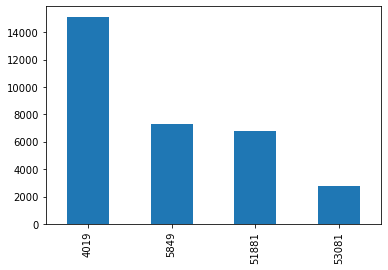

In [25]:
merged_df_filter_discharge['ICD9_CODE'].value_counts().plot(kind='bar')

In [26]:
X, y = merged_df_filter_discharge.TEXT, merged_df_filter_discharge.ICD9_CODE

## Text Cleaning {-}

In [27]:
my_stop_words = ['discharge', 'diagnosis', 'medications', 'medication', 'disposition', 'condition', 'instructions', 
                 'status', 'secondary', 'changes', 'instruction', 'change', 'home', 'name', 'hospital', 'daily',
                'hour', 'follow', 'care', 'time', 'day', 'week', 'with', 'disp', 'discharged', 'admitted', 
                 'namepattern', 'none']

In [28]:
documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    # Remove new line characters
    document = document.replace("\n", ' ')
    # Punctuation
    document = re.sub(r'[^\w\s]', ' ', document)
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    #Removing Numbers
    document = ''.join(i for i in document if not i.isdigit())
    #Removing Stopwords
    document = ' '.join([i for i in document.split() if not i in all_stopwords])
    #Removing certain sized words
    document = ' '.join([i for i in document.split() if len(i)>3])
    # Contractions
    document = contractions.fix(document)
    # Converting to Lowercase
    document = document.lower()
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    #Removing my_stop_words
    document = ' '.join([i for i in document.split() if not i in my_stop_words])
    
    #return document
    documents.append(document)

In [29]:
X = documents
X

['lasix weigh everyday weighs pound tablet lasix last stitle weighs pound hold lasix last stitle pantoprazole sodium tablet delayed release tablet atorvastatin carvedilol coreg isosorbide mononitrate tablet sustained release imdur hydralazine good',
 '',
 'primary respiratory failure mucous plugging acute chronic systolic heart failure complex vitamin folic acid capsule aspirin tablet chewable tablet chewable atorvastatin tablet tablet calcium carbonate calcium tablet chewable tablet chewable meal meal camphor menthol lotion appl topical needed itching toprol tablet extended release tablet extended release extended mental clear coherent level consciousness alert interactive activity assistance chair wheelchair pleasure taking hospitalization hospitalized respiratory failure mucous plug lung excess volume lung intubated hospitalization subsequently exutabted during hosptialization found depressed pumping function heart called systolic heart failure concerning missed heart attack decisio

In [30]:
type(X)

list

## TFIDF Vectorizer {-}

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [33]:
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df

,_____,_________,__________,___________,_____________,______________,_______________,___________________,____________________,_________________________,...,zovia,zyban,zyflo,zygoma,zygomatic,zyprexa,zyrpexa,zyrtec,zytiga,zyvox
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting Training and Testing Sets {-}

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Training Models {-}

In [36]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Logistic Regression Multi-class
from sklearn.linear_model import LogisticRegression #multi_class = 'multinomial'

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Linear Support Vector Classifier
from sklearn.svm import LinearSVC #multi_class=”crammer_singer”

In [37]:
classifier_1 = DecisionTreeClassifier()
classifier_1.fit(X_train, y_train)

DecisionTreeClassifier()

In [38]:
classifier_2 = MultinomialNB()
classifier_2.fit(X_train, y_train)

MultinomialNB()

In [39]:
classifier_3 = LogisticRegression(multi_class = 'multinomial')
classifier_3.fit(X_train, y_train)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [40]:
classifier_4 = RandomForestClassifier()
classifier_4.fit(X_train, y_train)

RandomForestClassifier()

In [41]:
classifier_5 = LinearSVC(multi_class = 'crammer_singer')
classifier_5.fit(X_train, y_train)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(multi_class='crammer_singer')

## Testing Models {-}

In [42]:
y_pred_dtc = classifier_1.predict(X_test)

In [43]:
y_pred_mnb = classifier_2.predict(X_test)

In [44]:
y_pred_lr = classifier_3.predict(X_test)

In [45]:
y_pred_rfc = classifier_4.predict(X_test)

In [46]:
y_pred_lsvc = classifier_5.predict(X_test)

## Evaluating Each Model {-}

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [48]:
print('DECISION TREE RESULTS\n')
print(confusion_matrix(y_test,y_pred_dtc))
print(classification_report(y_test,y_pred_dtc))
print(accuracy_score(y_test, y_pred_dtc))

DECISION TREE RESULTS

[[4096  176  128  109]
 [1823  250   92   40]
 [1704  105  222   27]
 [ 713   42   28   39]]
              precision    recall  f1-score   support

        4019       0.49      0.91      0.64      4509
        5849       0.44      0.11      0.18      2205
       51881       0.47      0.11      0.18      2058
       53081       0.18      0.05      0.08       822

    accuracy                           0.48      9594
   macro avg       0.40      0.29      0.27      9594
weighted avg       0.45      0.48      0.39      9594

0.4801959558057119


In [49]:
print('MULTINOMIAL NAIVE BAYES RESULTS\n')
print(confusion_matrix(y_test,y_pred_mnb))
print(classification_report(y_test,y_pred_mnb))
print(accuracy_score(y_test, y_pred_mnb))

MULTINOMIAL NAIVE BAYES RESULTS

[[4469    5   35    0]
 [2142   20   43    0]
 [1950    7  101    0]
 [ 812    2    8    0]]
              precision    recall  f1-score   support

        4019       0.48      0.99      0.64      4509
        5849       0.59      0.01      0.02      2205
       51881       0.54      0.05      0.09      2058
       53081       0.00      0.00      0.00       822

    accuracy                           0.48      9594
   macro avg       0.40      0.26      0.19      9594
weighted avg       0.48      0.48      0.33      9594

0.47842401500938087


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
print('LOGISITIC REGRESSION RESULTS\n')
print(confusion_matrix(y_test,y_pred_lr))
print(classification_report(y_test,y_pred_lr))
print(accuracy_score(y_test, y_pred_lr))

LOGISITIC REGRESSION RESULTS

[[4356   76   76    1]
 [1851  274   80    0]
 [1743   73  242    0]
 [ 758   35   25    4]]
              precision    recall  f1-score   support

        4019       0.50      0.97      0.66      4509
        5849       0.60      0.12      0.21      2205
       51881       0.57      0.12      0.20      2058
       53081       0.80      0.00      0.01       822

    accuracy                           0.51      9594
   macro avg       0.62      0.30      0.27      9594
weighted avg       0.56      0.51      0.40      9594

0.5082343131123619


In [51]:
print('RANDOM FOREST RESULTS\n')
print(confusion_matrix(y_test,y_pred_rfc))
print(classification_report(y_test,y_pred_rfc))
print(accuracy_score(y_test, y_pred_rfc))

RANDOM FOREST RESULTS

[[4405   47   57    0]
 [1897  254   54    0]
 [1784   76  197    1]
 [ 781   24   17    0]]
              precision    recall  f1-score   support

        4019       0.50      0.98      0.66      4509
        5849       0.63      0.12      0.19      2205
       51881       0.61      0.10      0.17      2058
       53081       0.00      0.00      0.00       822

    accuracy                           0.51      9594
   macro avg       0.43      0.30      0.25      9594
weighted avg       0.51      0.51      0.39      9594

0.5061496768813842


In [52]:
print('LINEAR SUPPORT VECTOR CLASSIFIER RESULTS\n')
print(confusion_matrix(y_test,y_pred_lsvc))
print(classification_report(y_test,y_pred_lsvc))
print(accuracy_score(y_test, y_pred_lsvc))

LINEAR SUPPORT VECTOR CLASSIFIER RESULTS

[[1029 3368   82   30]
 [ 221 1897   81    6]
 [ 158 1643  246   11]
 [ 161  618   28   15]]
              precision    recall  f1-score   support

        4019       0.66      0.23      0.34      4509
        5849       0.25      0.86      0.39      2205
       51881       0.56      0.12      0.20      2058
       53081       0.24      0.02      0.03       822

    accuracy                           0.33      9594
   macro avg       0.43      0.31      0.24      9594
weighted avg       0.51      0.33      0.29      9594

0.3321867834062956


## Feature Importance Ranking With Random Forest {-}

In [53]:
feature_importances=pd.DataFrame({'feature':vectorizer.get_feature_names(),'feature_importance':classifier_4.feature_importances_})
important_features = feature_importances.sort_values('feature_importance',ascending=False).head(40)
important_features

,feature,feature_importance
4400,expired,0.016094
4508,failure,0.011197
10156,renal,0.009612
10282,respiratory,0.009337
198,acute,0.007408
9037,pneumonia,0.006159
952,aspirin,0.005881
11822,tablet,0.005216
8487,pain,0.004970
6559,kidney,0.004929


In [54]:
important_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 4400 to 11086
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   feature             40 non-null     object 
 1   feature_importance  40 non-null     float64
dtypes: float64(1), object(1)
memory usage: 960.0+ bytes


In [55]:
important_features_list = list(important_features['feature'])
important_features_list

['expired',
 'failure',
 'renal',
 'respiratory',
 'acute',
 'pneumonia',
 'aspirin',
 'tablet',
 'pain',
 'kidney',
 'stable',
 'patient',
 'refill',
 'primary',
 'last',
 'release',
 'capsule',
 'extended',
 'needed',
 'metoprolol',
 'delayed',
 'please',
 'deceased',
 'unit',
 'number',
 'first',
 'breathing',
 'doctor',
 'bedtime',
 'twice',
 'chronic',
 'service',
 'acetaminophen',
 'fever',
 'fluid',
 'albuterol',
 'blood',
 'docusate',
 'shower',
 'sodium']

## Creating Important Features DataFrame Using TF-IDF {-}

In [56]:
words = tfidf_df[important_features_list]
label = merged_df_filter_discharge['ICD9_CODE']
age = merged_df_filter_discharge['AGE']

tfidf_feature_importances_with_age_df = pd.concat([age, label, words], axis=1)
tfidf_feature_importances_with_age_df

,AGE,ICD9_CODE,expired,failure,renal,respiratory,acute,pneumonia,aspirin,tablet,...,chronic,service,acetaminophen,fever,fluid,albuterol,blood,docusate,shower,sodium
0,51,5849,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.280809,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085831
1,65,51881,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,79,51881,0.0,0.153480,0.000000,0.094160,0.039996,0.0,0.090719,0.206375,...,0.042376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,65,51881,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,59,5849,0.0,0.132365,0.101278,0.054137,0.183967,0.0,0.034773,0.296638,...,0.048729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31972,65,53081,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
31973,73,53081,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
31974,79,4019,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
31975,51,4019,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [57]:
tfidf_feature_importances_with_age_df['ICD9_CODE'].isnull().sum()

0

In [58]:
tfidf_feature_importances_with_age_df['AGE'].isnull().sum()

0

In [59]:
#tfidf_feature_importances_with_age_df.to_csv('tfidf_discharge_mimic_no_zeros.csv', index=False)

## Building TFIDF with Top 6 Topic Model Words {-}

In [60]:
# topic_model_list = pd.read_csv('/Users/JoKerry/Desktop/CSML1030 - Machine Learning Capstone/3. Topic Modeling/topic_words_list_series_top_6_words_age_filtered.csv')
# topic_model_list

In [61]:
# topic_words_list = topic_model_list['0'].tolist()
# topic_words_list

In [62]:
# words = tfidf_df[topic_words_list]
# label = merged_df_filter_discharge['ICD9_CODE']
# age = merged_df_filter_discharge['AGE']

# tfidf_feature_importances_with_age_top_6_words_df = pd.concat([age, label, words], axis=1)
# tfidf_feature_importances_with_age_top_6_words_df

In [63]:
# tfidf_feature_importances_with_age_top_6_words_df['ICD9_CODE'].isnull().sum()

In [64]:
# tfidf_feature_importances_with_age_top_6_words_df['AGE'].isnull().sum()

In [65]:
# tfidf_feature_importances_with_age_top_6_words_df.to_csv('tfidf_feature_importances_with_age_filtered_top_6_words_df.csv', index=False)

## Sanity Check {-}

In [66]:
# tfidf_test = pd.read_csv('/Users/JoKerry/Desktop/CSML1030 - Machine Learning Capstone/2. Cleaning Balancing TFIDF/tfidf_feature_importances_imbalanced_with_age_filtered.csv')
# tfidf_test

In [67]:
# tfidf_feature_importances_with_age_top_6_words_test = pd.read_csv('tfidf_feature_importances_with_age_filtered_top_6_words_df.csv')
# tfidf_feature_importances_with_age_top_6_words_test

In [68]:
# topic_modeling_df_test = pd.read_csv('/Users/JoKerry/Desktop/CSML1030 - Machine Learning Capstone/3. Topic Modeling/topic_modeling_11_topics_with_age_filtered.csv')
# topic_modeling_df_test